In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import gpflow

ValueError: Arg specs do not match: original=FullArgSpec(args=['input', 'dtype', 'name', 'layout'], varargs=None, varkw=None, defaults=(None, None, None), kwonlyargs=[], kwonlydefaults=None, annotations={}), new=FullArgSpec(args=['input', 'dtype', 'name'], varargs=None, varkw=None, defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={}), fn=<function ones_like_v2 at 0x7fc6fa1e7d80>

In [ ]:
change_points = {
                "timeseries_01": "2024-08-30 07:50:00",
                "timeseries_02": "2024-07-23 09:00:00",
                "timeseries_03": "2024-06-20 08:05:00",
                "timeseries_04": "2024-09-05 08:30:00",
                "timeseries_05": "2024-09-02 17:00:00",
                "timeseries_06": "2024-09-05 08:30:00",
                "timeseries_07": "2023-04-19 12:05:00",
                "timeseries_08": "2023-04-19 12:05:00",
                "timeseries_09": "2023-06-14 17:45:00",
                "timeseries_10": "2023-05-22 02:30:00",
                "timeseries_11": "2023-06-12 06:55:00",
                "timeseries_12": "2023-03-17 15:20:00",
                "timeseries_13": "2023-06-06 10:40:00",
                "timeseries_14": "2023-09-28 07:35:00",
                "timeseries_15": "2023-07-14 15:30:00",
                "timeseries_16": "2023-06-27 08:15:00",
                "timeseries_17": "2022-12-06 08:25:00",
                "timeseries_18": "2021-11-29 11:00:00",
                "timeseries_19": "2021-09-17 07:10:00",
                "timeseries_20": "2022-01-03 15:15:00"
                }



In [ ]:
folder_name = './CHARGE_timeseries/'

folder_path = Path(folder_name)

for file in folder_path.iterdir():
    if file.is_file():

        timeseries_nr = file.name[:-5] # remove .xlsx

        data = pd.read_excel(file)


        fig = plt.figure(figsize=[12,7])

        plt.plot(pd.to_datetime(data.TIMESTAMP), data.VALUE)
        plt.grid()
        plt.axhline(0, color = "black")
        plt.title(timeseries_nr)
        plt.ylabel("Active Power [kW]")
        plt.xlabel("Time")
        plt.axvline(pd.to_datetime(change_points[timeseries_nr]), linestyle = "--", color = "red")
        plt.savefig("./figures/ChangePoint_ts_"+str(timeseries_nr)+'.png')


In [ ]:
all_timeseries_file = [ file for file in folder_path.iterdir() if file.is_file() ]

all_timeseries_df = [pd.read_excel(file) for file in all_timeseries_file]

In [ ]:
# Add column with if there is a change point or not
for i, df in enumerate(all_timeseries_df):
    all_timeseries_df[i]["ChangePoint"] = 0
    if i+1 <= 9:
        i_str = "0"+str(i+1)
    else:
        i_str = str(i+1)
    all_timeseries_df[i]["change_point"] = 0
    all_timeseries_df[i].loc[all_timeseries_df[i].TIMESTAMP == change_points["timeseries_" + i_str], "change_point"] = 1

In [ ]:
# Create a train, val test split
import numpy as np
all_idx = list(range(len(all_timeseries_df)))

# Shuffle
np.random.shuffle(all_idx)

train_idx = all_idx[:int(0.7*len(all_timeseries_df))]
val_idx = all_idx[int(0.7*len(all_timeseries_df)):int(0.85*len(all_timeseries_df))]
test_idx = all_idx[int(0.85*len(all_timeseries_df)):]



In [ ]:
train_dfs = [all_timeseries_df[i] for i in train_idx]
val_dfs = [all_timeseries_df[i] for i in val_idx]
test_dfs = [all_timeseries_df[i] for i in test_idx]

In [ ]:
window_size = 16 # Corresponds to 4 hour
step_size = 4


    

In [ ]:
# Create a final dataset:

def create_dataset(dfs, window_size, step_size):
    final_dfs = []
    for df in dfs:

        for i in range(0, len(df)-window_size, step_size):
            values = df.VALUE[i:i+window_size].values
            change_point = max(df.iloc[i: i+window_size]["change_point"])
            final_dfs.append({"values": values, "change_point": change_point})

    final_dfs = pd.DataFrame(final_dfs)
    return final_dfs


train_dataset = create_dataset(train_dfs, window_size, step_size)
        
        

In [ ]:
train_dataset['change_point'].value_counts()

change_point
0    55733
1       56
Name: count, dtype: int64

In [ ]:
class RollingMeanDetectionModel():

    def __init__(self, window_size: int = 4, std_multiplier: float = 1.5):
        self.window_size = window_size
        self.std_multiplier = std_multiplier


    def predict(self, x: list[list[float]]) -> list[float]:

        predictions = []
        
        for row in x:
            first_window = row[:self.window_size]
            mean = np.mean(first_window)
            std = np.std(first_window)

            last_window = row[-self.window_size:]
            last_mean = np.mean(last_window)

            if abs(last_mean - mean) > self.std_multiplier * std:
                predictions.append(1)
            else:
                predictions.append(0)

        return predictions


In [ ]:
model = RollingMeanDetectionModel(window_size=4)

predictions = model.predict(train_dataset["values"].values)


In [ ]:
# Check if there are any positive predictions

np.sum(predictions)

np.int64(31369)

In [ ]:
change_points_training = train_dataset["change_point"].values

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(predictions, change_points_training):
    accuracy = accuracy_score(change_points_training, predictions)
    f1 = f1_score(change_points_training, predictions)
    precision = precision_score(change_points_training, predictions)
    recall = recall_score(change_points_training, predictions)

    return accuracy, f1, precision, recall

print(evaluate_model(predictions, change_points_training))


(0.43825843804334186, np.float64(0.0027366746221161495), np.float64(0.0013707800694953618), np.float64(0.7678571428571429))


In [ ]:
hyperparameters = {
    "window_size": [2, 4, 8, 12],
    "std_multiplier": [0.5, 1.5, 2, 2.5]
}

scores = []

for window_size in hyperparameters["window_size"]:
    for std_multiplier in hyperparameters["std_multiplier"]:
        model = RollingMeanDetectionModel(window_size=window_size, std_multiplier=std_multiplier)
        predictions = model.predict(train_dataset["values"].values)
        accuracy, f1, precision, recall = evaluate_model(predictions, change_points_training)
        scores.append({"window_size": window_size, "std_multiplier": std_multiplier, "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall})

        print(f"Window size: {window_size}, std_multiplier: {std_multiplier}, accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}")

Window size: 2, std_multiplier: 0.5, accuracy: 0.1769703705031458, f1: 0.0024333014686712434, precision: 0.0012181327764726356, recall: 1.0
Window size: 2, std_multiplier: 1.5, accuracy: 0.29351664306583736, f1: 0.0025307485954345296, precision: 0.001267170155608495, recall: 0.8928571428571429
Window size: 2, std_multiplier: 2, accuracy: 0.3396726953342057, f1: 0.0026531662019113624, precision: 0.0013285973807651637, recall: 0.875
Window size: 2, std_multiplier: 2.5, accuracy: 0.3721163670257578, f1: 0.0027898767329974095, precision: 0.0013971657494796271, recall: 0.875
Window size: 4, std_multiplier: 0.5, accuracy: 0.22896986861209198, f1: 0.0025507246376811595, precision: 0.0012770205948594115, recall: 0.9821428571428571
Window size: 4, std_multiplier: 1.5, accuracy: 0.43825843804334186, f1: 0.0027366746221161495, precision: 0.0013707800694953618, recall: 0.7678571428571429
Window size: 4, std_multiplier: 2, accuracy: 0.5084873362132319, f1: 0.003126476896789908, precision: 0.0015664

<Axes: >

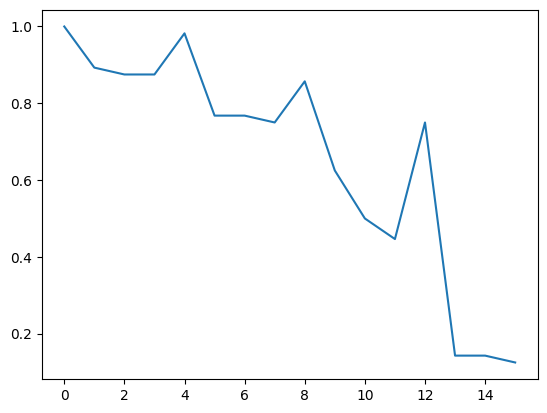

In [ ]:
# Plot the accuracy, f1, precision, recall for each hyperparameter combination

scores_df = pd.DataFrame(scores)


scores_df["recall"].plot()

<Axes: >

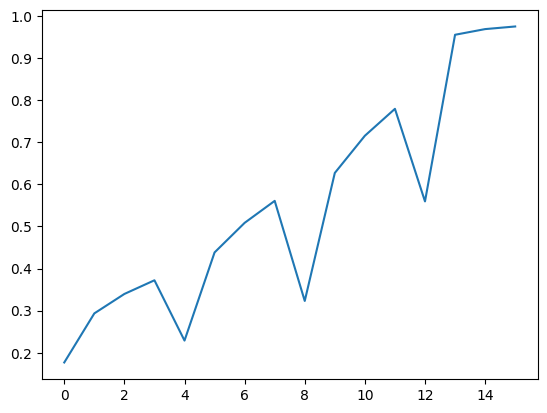

In [ ]:
scores_df["accuracy"].plot()

In [ ]:
import gpflow
from sklearn.preprocessing import MinMaxScaler

class GPModel:

    def predict(self, x: [float]) -> float:
        # Fit model 1
        predictions = []
        
        for row in x:
            k = gpflow.kernels.Matern32(lengthscales=0.2)
            model = gpflow.models.GPR(
                (np.ndarray(range(len(row))), row),
                kernel=k,
            )

            base_k1 = gpflow.kernels.Matern32(lengthscales=0.2)
            base_k2 = gpflow.kernels.Matern32(lengthscales=2.0) 
            k = gpflow.kernels.ChangePoints([base_k1, base_k2], [0.0], steepness=5.0)

            model_change_point = gpflow.models.GPR(
                (np.ndarray(range(len(row))), row),
                kernel=k,
            )

            opt = gpflow.optimizers.Scipy()

            def objective_closure(m):
                return m.training_loss()

            opt_logs = opt.minimize(objective_closure(model),
                                    model.trainable_variables,
                                    options=dict(maxiter=100))
            
            opt_logs_change_point = opt.minimize(objective_closure(model_change_point),
                                    model_change_point.trainable_variables,
                                    options=dict(maxiter=100))
            
            if opt_logs_change_point < opt_logs:
                predictions.append(1)
            else:
                predictions.append(0)        

        return predictions


AttributeError: module 'tensorflow_probability.python.layers' has no attribute 'internal'

In [ ]:
model = GPModel()

predictions = model.predict(train_dataset["values"].values)

NameError: name 'gpflow' is not defined

In [ ]:
train_dataset["values"].values

NameError: name 'train_dataset' is not defined

In [ ]:
!pip install gpflow